In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import re
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


### Reference
* https://www.kaggle.com/mnavaidd/tweet-classification-using-lstm-bert/notebook?select=glove.6B.zip
* https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert

In [2]:
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout
from tensorflow.keras.layers import SpatialDropout1D, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

import numpy as np
import pandas as pd

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

print("Tensorflow Version",tf.__version__)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Tensorflow Version 2.4.1


In [3]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 895 kB/s 


In [4]:
from spellchecker import SpellChecker

In [5]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2021-03-28 07:45:11--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-03-28 07:45:12--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-03-28 07:45:12--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [7]:
df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


# EDA
* Target Percent
* Keyword per Count
* Texts length per Target percent

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


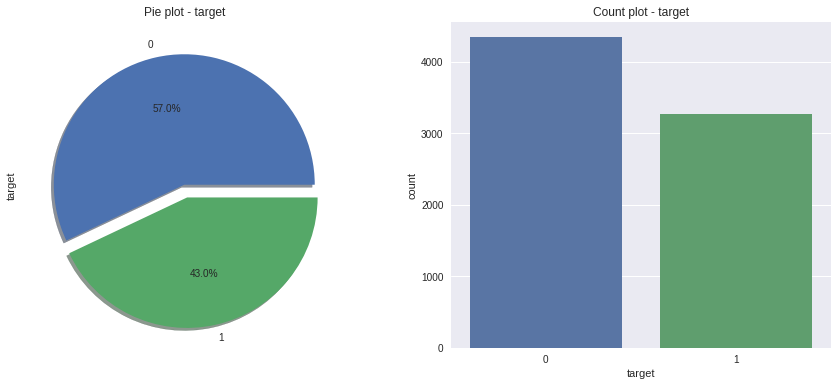

In [8]:

f,ax = plt.subplots(1,2,figsize=(15,6))
df['target'].value_counts().plot.pie(explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True)
ax[0].set_title('Pie plot - target')
sns.countplot('target', data=df, ax=ax[1])
ax[1].set_title('Count plot - target')
plt.show()
#target == 0 : negative(fake)
#tarege == 1 : postive(real)

In [9]:
keyword_unique = df['keyword'].unique()
keyword_unique

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


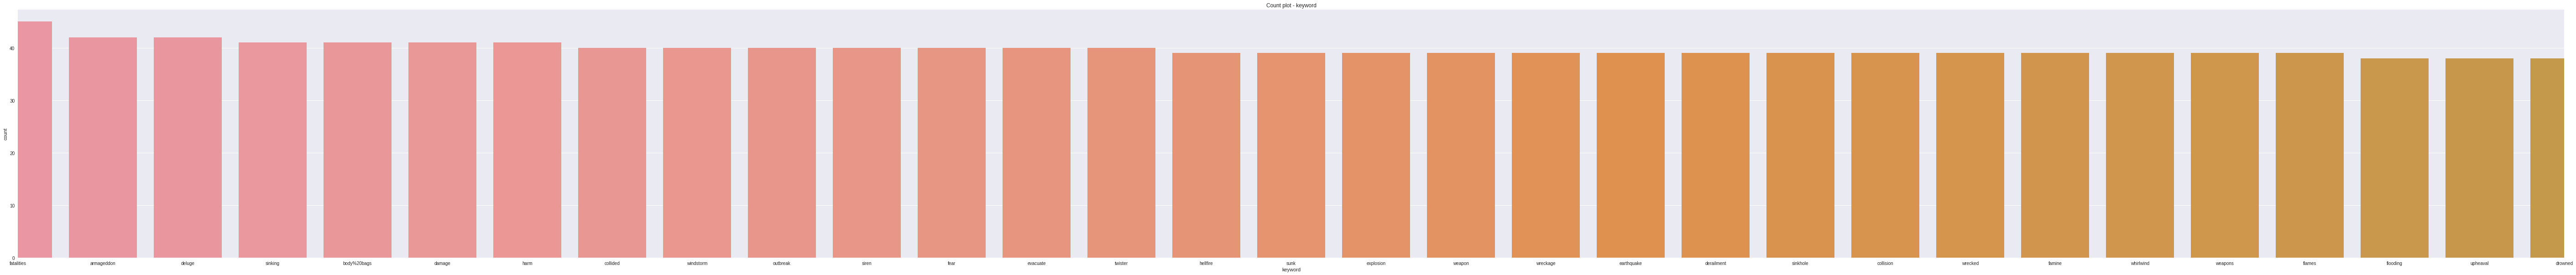

In [10]:
f,ax = plt.subplots(1,1,figsize=(100,10))
sns.countplot('keyword',data=df,ax=ax,order=df['keyword'].value_counts().index)
ax.set_title('Count plot - keyword')
ax.set_xlim(0,30)

plt.show()

In [11]:
def get_length(text):
    return len(text)

In [12]:
df['length'] = df['text'].apply(get_length)

In [13]:
df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


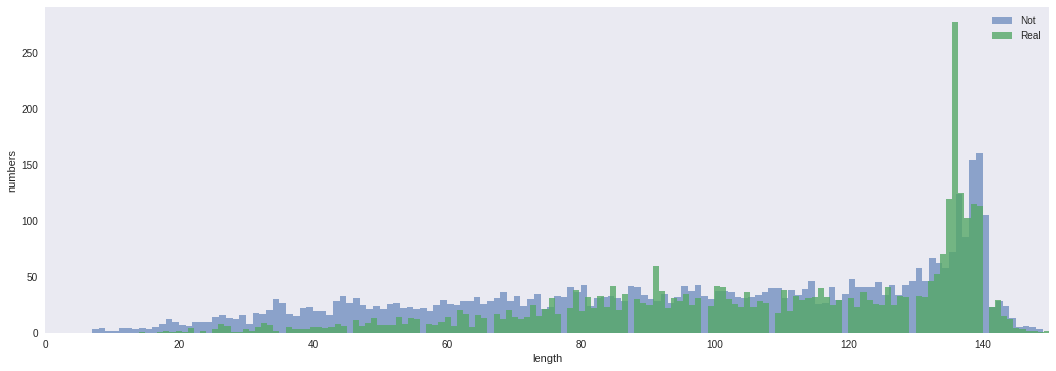

In [14]:
plt.figure(figsize=(18,6))
plt.hist(df[df['target'] == 0]['length'], alpha = 0.6, bins=150, label = 'Not')
plt.hist(df[df['target'] == 1]['length'], alpha = 0.8, bins=150, label = 'Real')
plt.xlabel('length')
plt.ylabel('numbers')
plt.legend(loc='upper right')
plt.xlim(0,150)
plt.grid()
plt.show()

# Preprocessing
* Null Value Processing

In [15]:
df.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
length         0
dtype: int64

In [16]:
df['keyword'].fillna("", inplace = True)
df['location'].fillna("unknow",inplace = True)
df.isnull().sum()

id          0
keyword     0
location    0
text        0
target      0
length      0
dtype: int64

# Feature Engineering
* Nomalization
* Drop Columns
* Plot WordClouds
* Words Tokenization
* Words Embedding (Glove)

In [17]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [18]:
def preprocess(text,stem=False):
    text = text.lower()  # lowercase

    text = re.sub(r'[!]+', '!', text)
    text = re.sub(r'[?]+', '?', text)
    text = re.sub(r'[.]+', '.', text)
    text = re.sub(r"'", "", text)
    text = re.sub('\s+', ' ', text).strip()  # Remove and double spaces
    text = re.sub(r'&amp;?', r'and', text)  # replace & -> and
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text)  # Remove URLs
    # remove some puncts (except . ! # ?)
    text = re.sub(r'[:"$%&\*+,-/:;<=>@\\^_`{|}~]+', '', text)
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'EMOJI', text)
    
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [19]:
spell = SpellChecker()
def correct_spell(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [20]:
text = "corect"
correct_spell(text)

'correct'

In [21]:
df.text = df.text.apply(lambda x: preprocess(x))
#df.text = df.text.apply(lambda x: correct_spell(x))

#### Word Cloud
* fake target
* real target

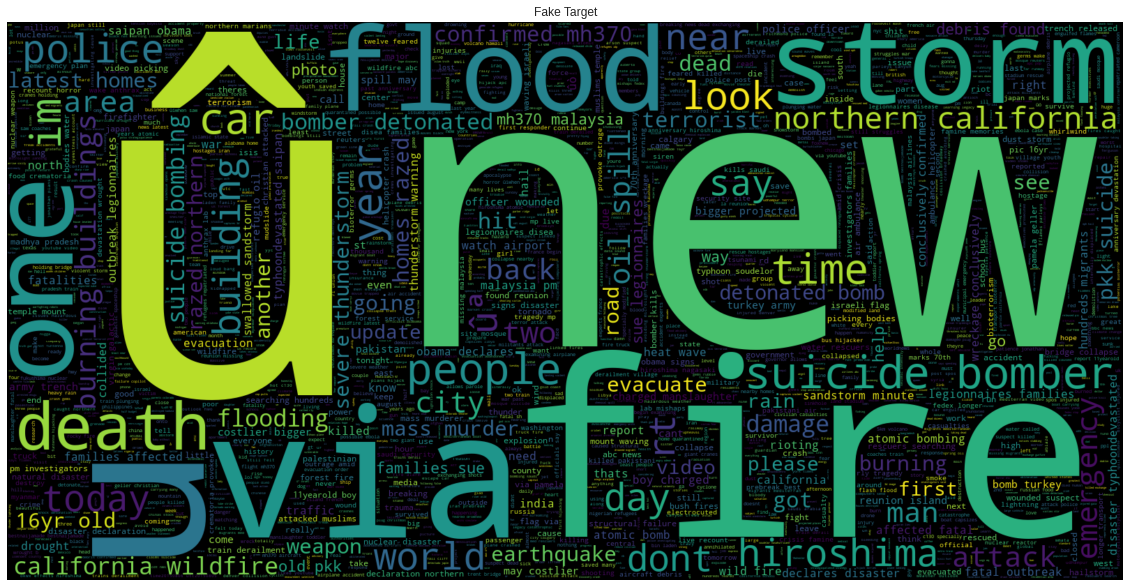

In [22]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.target == 1].text))
plt.axis('off')
plt.title('Fake Target')
plt.imshow(wc,interpolation = 'bilinear')

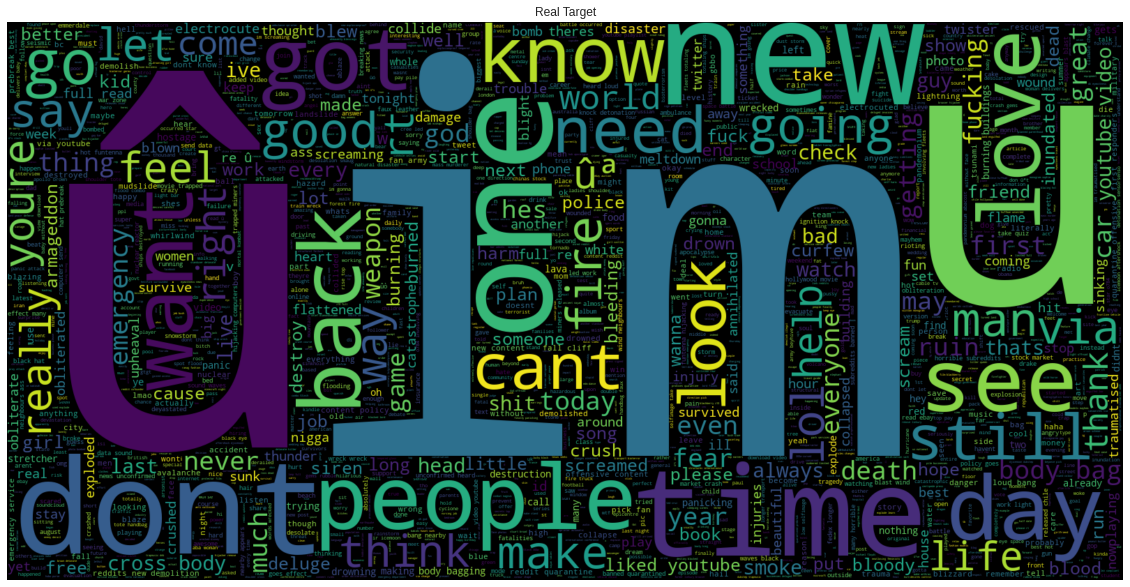

In [23]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.target == 0].text))
plt.axis('off')
plt.title('Real Target')
plt.imshow(wc,interpolation = 'bilinear')

In [24]:
df.head(10)

,id,keyword,location,text,target,length
0,1,,unknow,deeds reason #earthquake may allah forgive us,1,69
1,4,,unknow,forest fire near la ronge sask canada,1,38
2,5,,unknow,residents asked shelter place notified officer...,1,133
3,6,,unknow,13000 people receive #wildfires evacuation ord...,1,65
4,7,,unknow,got sent photo ruby #alaska smoke #wildfires p...,1,88
5,8,,unknow,#rockyfire update california hwy 20 closed dir...,1,110
6,10,,unknow,#flood #disaster heavy rain causes flash flood...,1,95
7,13,,unknow,im top hill see fire woods,1,59
8,14,,unknow,theres emergency evacuation happening building...,1,79
9,15,,unknow,im afraid tornado coming area,1,52


In [25]:
df.drop(['keyword','id','location','length'],axis=1,inplace=True)
df.head(10)

,text,target
0,deeds reason #earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,13000 people receive #wildfires evacuation ord...,1
4,got sent photo ruby #alaska smoke #wildfires p...,1
5,#rockyfire update california hwy 20 closed dir...,1
6,#flood #disaster heavy rain causes flash flood...,1
7,im top hill see fire woods,1
8,theres emergency evacuation happening building...,1
9,im afraid tornado coming area,1


In [26]:
train_data, test_data = train_test_split(df,test_size = 0.2)
print("Train Data size : ",len(train_data))
print("Test Data size : ",len(test_data))

Train Data size :  6090
Test Data size :  1523


In [27]:
train_data.head(10)

,text,target
5462,oops bounty hunters try raid phoenix police ch...,1
4067,us forest service says spending half budget fi...,1
960,check ameribag healthy back bag shoulder cross...,0
1076,hiroshima marks 70 years since bomb,1
1726,2 pple confirmed dead 20 rescued many went mis...,1
3937,spot flood combo 53inch 300w curved cree led w...,0
170,could drone cause airplane accident? pilots wo...,1
5950,camilacabello97 internally externally screaming,1
3602,investigators shift focus cause fatal waimate ...,1
3742,misshomasttopa cause fire fire fire yeah fire ...,1


In [28]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
print("Vocab size : ",vocab_size)

Vocab size :  15645


In [29]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = 30)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text), maxlen = 30)


print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (6090, 30)
Testing X Shape: (1523, 30)


In [30]:
y_train = train_data.target
y_test = test_data.target

print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print(y_train,y_test)

y_train shape: (6090,)
y_test shape: (1523,)
5462    1
4067    1
960     0
1076    1
1726    1
       ..
4761    1
4910    1
7308    1
6391    1
2340    1
Name: target, Length: 6090, dtype: int64 1896    0
6331    1
5700    0
6619    1
5189    0
       ..
1716    1
723     0
2138    0
3624    1
6879    0
Name: target, Length: 1523, dtype: int64


In [31]:
GLOVE_EMB = '/kaggle/working/glove.6B.300d.txt'
EMBEDDING_DIM = 300
LR = 1e-3
BATCH_SIZE = 512

In [32]:
embeddings_index = {}

f = open(GLOVE_EMB)
for line in f:
    values = line.split()
    word = value = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' %len(embeddings_index))

Found 400000 word vectors.


In [33]:
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [34]:
embedding_layer = tf.keras.layers.Embedding(vocab_size,
                                            EMBEDDING_DIM,
                                            weights=[embedding_matrix],
                                            input_length = 30,
                                            trainable=False)

# Modeling
* Use LSTM

In [35]:
inputs = Input(shape=(30,),dtype = 'int32')

embedding = embedding_layer(inputs)
net = SpatialDropout1D(0.2)(embedding)
net = Bidirectional(LSTM(64,dropout=0.2, recurrent_dropout=0.2))(net)
net = Dense(1,activation = 'sigmoid')(net)

outputs = net
model = tf.keras.Model(inputs,outputs)

In [36]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [37]:
callback = ReduceLROnPlateau(factor=0.1,
                    min_lr = 0.01,
                    monitor = 'val_loss',
                    verbose = 1)

In [38]:
history = model.fit(x_train,
                    y_train,
                    batch_size=BATCH_SIZE,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks = [callback])

Epoch 1/10
12/12 [==============================] - 11s 467ms/step - loss: 0.6604 - accuracy: 0.6247 - val_loss: 0.5319 - val_accuracy: 0.7754
Epoch 2/10
12/12 [==============================] - 4s 335ms/step - loss: 0.5206 - accuracy: 0.7698 - val_loss: 0.4590 - val_accuracy: 0.7905
Epoch 3/10
12/12 [==============================] - 4s 337ms/step - loss: 0.4588 - accuracy: 0.7966 - val_loss: 0.4359 - val_accuracy: 0.8011
Epoch 4/10
12/12 [==============================] - 4s 352ms/step - loss: 0.4364 - accuracy: 0.8022 - val_loss: 0.4283 - val_accuracy: 0.8030
Epoch 5/10
12/12 [==============================] - 4s 352ms/step - loss: 0.4129 - accuracy: 0.8212 - val_loss: 0.4245 - val_accuracy: 0.8017
Epoch 6/10
12/12 [==============================] - 5s 450ms/step - loss: 0.4174 - accuracy: 0.8140 - val_loss: 0.4303 - val_accuracy: 0.8056
Epoch 7/10
12/12 [==============================] - 4s 337ms/step - loss: 0.4060 - accuracy: 0.8227 - val_loss: 0.4285 - val_accuracy: 0.8083
Epoch

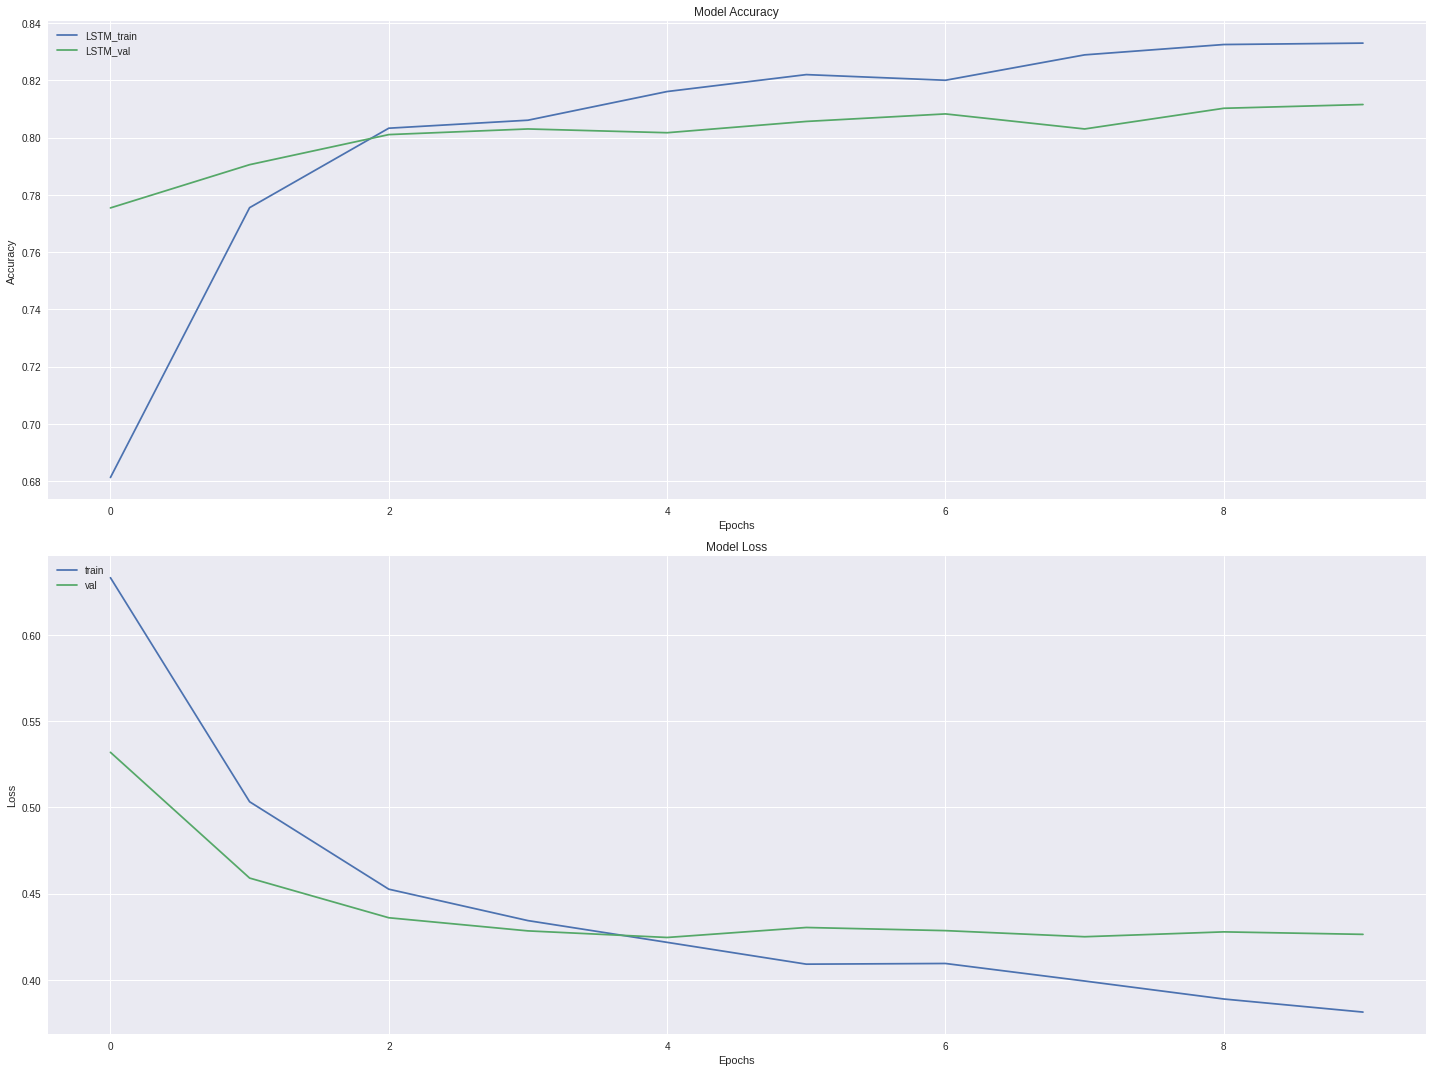

In [39]:

f,ax = plt.subplots(2,1,figsize=(20,15))

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Model Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].legend(['LSTM_train', 'LSTM_val'], loc='upper left')


ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Model Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
ax[1].legend(['train', 'val'], loc = 'upper left')

f.tight_layout()
plt.show()

# Submission
* get sample_submission.csv
* get test.csv

In [40]:
sample = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [41]:
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


In [42]:
test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [43]:
test.text = test.text.apply(lambda x: preprocess(x))

In [44]:
test.drop(['keyword','id','location',],axis=1,inplace=True)
test.head(10)

,text
0,happened terrible car crash
1,heard #earthquake different cities stay safe e...
2,forest fire spot pond geese fleeing across str...
3,apocalypse lighting #spokane #wildfires
4,typhoon soudelor kills 28 china taiwan
5,shakingits earthquake
6,theyd probably still show life arsenal yesterd...
7,hey! you?
8,nice hat?
9,fuck off!


In [45]:
test.shape

(3263, 1)

In [46]:
test = pad_sequences(tokenizer.texts_to_sequences(test.text), maxlen = 30)

print("test Shape:",test.shape)

test Shape: (3263, 30)


In [47]:
#test = df_test['id'].astype(int) # TYPE issue

prediction = model.predict(test)
prediction = list(1 if x>0.5 else 0 for x in list(prediction))
prediction.head()

AttributeError: 'list' object has no attribute 'head'

In [48]:
sample['target'] = prediction
sample['target'].value_counts()

0    2126
1    1137
Name: target, dtype: int64

In [49]:
sample.to_csv('submission.csv',index=False)

### THX to Reading My Notebook🌈